# Task Allocation Problem in Human Robot Collaboration

In [3]:
import pulp
import numpy as np

## 1. Indices

In [4]:
num_tasks = 8
agents = ['L', 'R', 'B']
tasks = ['T'+str(k+1) for k in range(num_tasks)]
assign = [(i, k)  for i in tasks for k in agents]
pred = [(i, j, k) for k in agents for j in tasks for i in tasks if i != j]

## 2. Dependent Tasks and Simutanious Tasks

In [5]:
dept_tasks = [('T1', 'T2'), ('T1', 'T3')]
simu_tasks = [('T2', 'T3'), ('T2', 'T4')]

## 3. Process Times

In [6]:
P = dict()
for aa in assign:
    if aa[1] == 'B':
        P[aa] = 1.0
    else:
        P[aa] = 2.0
M = 1000
P['T3', 'L'] = 20
P['T3', 'R'] = 20
P['T3', 'B'] = 10

## 4. Define Variables

In [7]:
emax = pulp.LpVariable('makespan', 0, 1000)
s = pulp.LpVariable.dicts('s', tasks, 0, 1000)
delta = pulp.LpVariable.dicts('delta', assign, 0, 1, pulp.LpInteger)
y = pulp.LpVariable.dicts('y', pred, 0, 1, pulp.LpInteger)

## 5. Solve the Optimization Model

In [8]:
prob = pulp.LpProblem("human-robot-collaboration-task-allocation", pulp.LpMinimize)
prob += emax

for i in tasks:
    prob += s[i] + pulp.lpSum([delta[i, k] * P[i, k] for k in agents]) <= emax
    
for i in tasks:
    prob += pulp.lpSum([delta[i, k] for k in agents]) == 1

for (i, j, k) in pred:
    prob += s[i] + P[i, k] <= s[j] + M*(1 - y[i, j, k])

for (i, j, k) in pred:
    prob += y[i, j, k] + y[j, i, k] <= 1

for (i, j, k) in pred:
    prob += y[i, j, k] + y[j, i, k] >= delta[i, k] + delta[j, k] - 1

for (i, j) in dept_tasks:
    prob += s[i] + pulp.lpSum([P[i,k] * delta[i, k] for k in agents]) <= s[j]

for (i, j) in simu_tasks:
    prob += s[i] == s[j]
    
prob.solve()
print(pulp.value(prob.objective))
# for v in prob.variables():
#     print(v.name, "=", v.varValue)
# pulp.LpConstraint(prob)

11.0


## 6. Print the output

In [9]:
assign_opt_task = dict()
proctime_opt_task = dict()
for ii in tasks:
    assign_opt_task[ii] = [k for (i, k) in list(delta) if (delta[i,k].value() == 1 and i == ii)][0]
    proctime_opt_task[ii] = [P[i,k] for (i, k) in list(delta) if (delta[i,k].value() == 1 and i == ii)][0]

print('Task   '+'Assign    '+'Start    '+'Proc')
print('------------------------------------')
for i in tasks:
    
    print(i+'     '+ assign_opt_task[i]+'         '+ '{:.2f}'.format(s[i].value())+'     '+'{:.2f}'.format(proctime_opt_task[i]))

Task   Assign    Start    Proc
------------------------------------
T1     B         0.00     1.00
T2     L         1.00     2.00
T3     B         1.00     10.00
T4     R         1.00     2.00
T5     L         5.00     2.00
T6     R         5.00     2.00
T7     L         3.00     2.00
T8     R         3.00     2.00


In [10]:
assign_opt = dict()
schedule_opt = dict()
for kk in agents:
    unsorted_tasks = [i for (i, k) in list(delta) if (delta[i,k].value() == 1 and k == kk)]
    unsorted_start = [s[i].value() for i in unsorted_tasks]
    sorted_tasks = [i for _,i in sorted(zip(unsorted_start,unsorted_tasks))]
    assign_opt[kk]  = sorted_tasks
    schedule_opt[kk] = [(s[i].value(), P[i,kk]) for i in assign_opt[kk]]
print(schedule_opt)

{'L': [(1.0, 2.0), (3.0, 2.0), (5.0, 2.0)], 'R': [(1.0, 2.0), (3.0, 2.0), (5.0, 2.0)], 'B': [(0.0, 1.0), (1.0, 10)]}


## 7. Gantt Chart

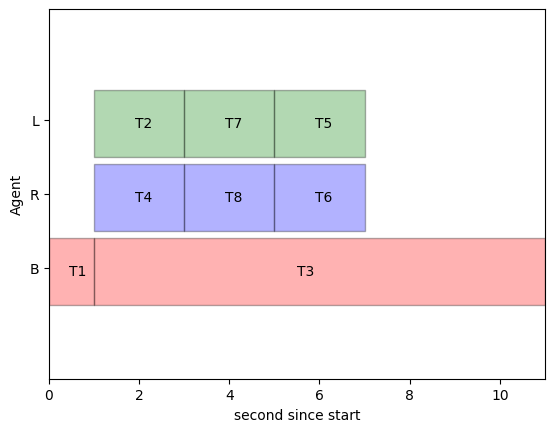

In [11]:
#Gantt Chart
# Importing the matplotlib.pyplot
import matplotlib.pyplot as plt

# Declaring a figure "gnt"
fig, gnt = plt.subplots()

# Setting Y-axis limits
gnt.set_ylim(0, 50)

# Setting X-axis limits
gnt.set_xlim(0, emax.value())

# Setting labels for x-axis and y-axis
gnt.set_xlabel('second since start')
gnt.set_ylabel('Agent')

# Setting ticks on y-axis
gnt.set_yticks([15, 25, 35])
# Labelling tickes of y-axis
gnt.set_yticklabels(['B', 'R', 'L'])

# Setting graph attribute
# gnt.grid(True, axis='y')

# Declaring a bar in schedule
gnt.broken_barh(schedule_opt['B'], (10, 9),
                         facecolors=('r'),
                         edgecolors=('k'),
                         alpha = .3)
# Declaring multiple bars in at same level and same width
gnt.broken_barh(schedule_opt['R'], (20, 9),
                         facecolors=('b'),
                         edgecolors=('k'),
                         alpha = .3)
gnt.broken_barh(schedule_opt['L'], (30, 9),
                         facecolors=('g'),
                         edgecolors=('k'), 
                         alpha = .3)

# Delaring task name in schedules
for (sch, task) in zip(schedule_opt['B'],assign_opt['B']):
    gnt.text(sch[0]+(.45)*sch[1], 15-1, task)
for (sch, task) in zip(schedule_opt['R'],assign_opt['R']):
    gnt.text(sch[0]+(.45)*sch[1], 25-1, task)
for (sch, task) in zip(schedule_opt['L'],assign_opt['L']):
    gnt.text(sch[0]+(.45)*sch[1], 35-1, task)